In [61]:
from pathlib import Path
import pandas as pd
import numpy as np

# -------- path helper (same as in 01GNDataPipeline) -------- #
def find_upwards(rel_path: Path, max_up: int = 8) -> Path:
    here = Path.cwd()
    for parent in [here, *here.parents][: max_up + 1]:
        candidate = (parent / rel_path)
        if candidate.exists():
            return candidate.resolve()
    raise FileNotFoundError(
        f"Couldn't locate '{rel_path.as_posix()}' from {here} by walking up {max_up} levels."
    )

# -------- files -------- #
DATA_DIR   = find_upwards(Path("GrossToNet/Data"))
DEALS_CSV  = DATA_DIR / "deal_cash_flow.csv"
FUNDS_CSV  = DATA_DIR / "fund_cash_flow.csv"
MAP_CSV    = DATA_DIR / "deal_to_fund.csv"  # optional

date_parser = lambda s: pd.to_datetime(s, format="%Y-%m-%d", errors="coerce")

# --- load cash flows (dates are yyyy-mm-dd) ---
deals = pd.read_csv(
    DEALS_CSV,
    dtype={"id": str, "deal_id": str},
)
funds = pd.read_csv(
    FUNDS_CSV,
    dtype={"id": str, "fund_id": str},
)

# parse dates explicitly (yyyy-mm-dd)
deals["cash_flow_date"] = pd.to_datetime(deals["cash_flow_date"], format="%Y-%m-%d", errors="coerce")
funds["cash_flow_date"] = pd.to_datetime(funds["cash_flow_date"], format="%Y-%m-%d", errors="coerce")

# standardize column names
deals = deals.rename(columns={"cash_flow_date": "date", "cash_flow": "amount"})
funds = funds.rename(columns={"cash_flow_date": "date", "cash_flow": "amount"})


# optional: deal→fund map (if present)
if MAP_CSV.exists():
    deal_to_fund = pd.read_csv(MAP_CSV, dtype={"deal_id": str, "fund_id": str})
else:
    deal_to_fund = pd.DataFrame(columns=["deal_id", "fund_id"])

# quick sanity checks
assert {"id", "deal_id", "amount", "date"}.issubset(deals.columns), deals.columns
assert {"id", "fund_id", "amount", "date"}.issubset(funds.columns), funds.columns


In [62]:
# ---------- Normalize types and enforce sign conventions ---------- #

# Pre-checks
req_f_cols = {"id", "fund_id", "amount", "date", "cash_flow_type"}
req_d_cols = {"id", "deal_id", "amount", "date", "cash_flow_type"}
assert req_f_cols.issubset(funds.columns), f"Missing in funds: {req_f_cols - set(funds.columns)}"
assert req_d_cols.issubset(deals.columns), f"Missing in deals: {req_d_cols - set(deals.columns)}"
assert pd.api.types.is_datetime64_any_dtype(funds["date"]), "funds.date must be datetime"
assert pd.api.types.is_datetime64_any_dtype(deals["date"]), "deals.date must be datetime"
assert funds["amount"].dtype.kind in "fi", "funds.amount must be numeric"
assert deals["amount"].dtype.kind in "fi", "deals.amount must be numeric"
assert funds["date"].notna().all(), "NaT in funds.date"
assert deals["date"].notna().all(), "NaT in deals.date"

# Canonicalize cash_flow_type
funds_map = {
    "contribution": "contribution",
    "distribution": "distribution",
    "nav": "nav",
}
deals_map = {
    "investment": "investment",
    "proceed": "proceed",
    "fair value": "fair_value",
}

funds["type_std"] = (
    funds["cash_flow_type"].astype(str).str.strip().str.lower().map(funds_map)
)
deals["type_std"] = (
    deals["cash_flow_type"].astype(str).str.strip().str.lower().map(deals_map)
)

# Validate types are known
unknown_f = funds[funds["type_std"].isna()]["cash_flow_type"].value_counts()
unknown_d = deals[deals["type_std"].isna()]["cash_flow_type"].value_counts()
assert unknown_f.empty, f"Unknown funds cash_flow_type: \n{unknown_f}"
assert unknown_d.empty, f"Unknown deals cash_flow_type: \n{unknown_d}"

# Enforce signs deterministically (use abs to avoid double flips)
# Funds: contribution negative; distribution/NAV non-negative
funds.loc[funds["type_std"] == "contribution", "amount"] = -funds.loc[
    funds["type_std"] == "contribution", "amount"
].abs()
funds.loc[funds["type_std"].isin(["distribution", "nav"]), "amount"] = funds.loc[
    funds["type_std"].isin(["distribution", "nav"]), "amount"
].abs()

# Deals: investment negative; proceed/fair_value non-negative
deals.loc[deals["type_std"] == "investment", "amount"] = -deals.loc[
    deals["type_std"] == "investment", "amount"
].abs()
deals.loc[deals["type_std"].isin(["proceed", "fair_value"]), "amount"] = deals.loc[
    deals["type_std"].isin(["proceed", "fair_value"]), "amount"
].abs()

#======= Only keep latest NAV/Fair Value snapshots to avoid double counting ========
# Funds: keep only last NAV per fund_id
nav = funds[funds.type_std=='nav']
keep_nav = nav.loc[nav.groupby('fund_id')['date'].idxmax()]
funds = pd.concat([funds[funds.type_std!='nav'], keep_nav], ignore_index=True)

# Deals: keep only last fair_value per deal_id
fv = deals[deals.type_std=='fair_value']
keep_fv = fv.loc[fv.groupby('deal_id')['date'].idxmax()]
deals = pd.concat([deals[deals.type_std!='fair_value'], keep_fv], ignore_index=True)
# ===================================================================================

# Post-conditions: strict sign checks
assert (funds.loc[funds["type_std"] == "contribution", "amount"] <= 0).all(), \
    "Found positive contribution amounts in funds."
assert (funds.loc[funds["type_std"].isin(["distribution", "nav"]), "amount"] >= 0).all(), \
    "Found negative distribution/NAV amounts in funds."

assert (deals.loc[deals["type_std"] == "investment", "amount"] <= 0).all(), \
    "Found positive investment amounts in deals."
assert (deals.loc[deals["type_std"].isin(["proceed", "fair_value"]), "amount"] >= 0).all(), \
    "Found negative proceed/fair_value amounts in deals."

# Quick summaries (useful for spot checks)
print("Funds types:\n", funds["type_std"].value_counts(dropna=False).to_string())
print("Deals types:\n", deals["type_std"].value_counts(dropna=False).to_string())
print(
    "Funds sign check:",
    {
        "contribution_min": float(funds.loc[funds.type_std=="contribution","amount"].min())
            if (funds.type_std=="contribution").any() else None,
        "dist_nav_min": float(funds.loc[funds.type_std.isin(["distribution","nav"]),"amount"].min())
            if (funds.type_std.isin(["distribution","nav"])).any() else None,
    }
)
print(
    "Deals sign check:",
    {
        "investment_min": float(deals.loc[deals.type_std=="investment","amount"].min())
            if (deals.type_std=="investment").any() else None,
        "proc_fv_min": float(deals.loc[deals.type_std.isin(["proceed","fair_value"]),"amount"].min())
            if (deals.type_std.isin(["proceed","fair_value"])).any() else None,
    }
)

print(funds.groupby('type_std')['amount'].sum())
print(deals.groupby('type_std')['amount'].sum())
print("Funds date range:", funds['date'].min(), funds['date'].max())
print("Deals date range:", deals['date'].min(), deals['date'].max())


Funds types:
 type_std
contribution    4549
distribution    2634
nav               96
Deals types:
 type_std
proceed       5870
investment    5656
fair_value     584
Funds sign check: {'contribution_min': -17352054794.5205, 'dist_nav_min': 5.551115123125779e-11}
Deals sign check: {'investment_min': -3285071667.0, 'proc_fv_min': 0.0}
type_std
contribution   -2.963110e+11
distribution    4.236794e+11
nav             1.513824e+11
Name: amount, dtype: float64
type_std
fair_value    1.531186e+11
investment   -1.841998e+11
proceed       1.759217e+11
Name: amount, dtype: float64
Funds date range: 1994-04-06 00:00:00 2025-06-30 00:00:00
Deals date range: 1992-07-02 00:00:00 2025-04-01 00:00:00


In [63]:
from pathlib import Path
import pandas as pd
import numpy as np

# ---------- Locate & read monthly FX (Excel-serial dates; wide -> tidy) ----------
def find_upwards(rel_path: Path, max_up: int = 8) -> Path:
    here = Path.cwd()
    for parent in [here, *here.parents][: max_up + 1]:
        candidate = (parent / rel_path)
        if candidate.exists():
            return candidate.resolve()
    raise FileNotFoundError(f"Couldn't locate '{rel_path.as_posix()}' from {here} by walking up {max_up} levels.")

FX_WIDE_CSV = find_upwards(Path("InputData/currencies.csv"))
fx_wide = pd.read_csv(FX_WIDE_CSV)

# Validate minimal structure
assert "date" in fx_wide.columns, f"'date' column missing in {FX_WIDE_CSV}"
ccy_cols = [c for c in fx_wide.columns if c != "date"]
assert ccy_cols, "No currency columns found in currencies.csv (expected like USD, EUR, GBP, ...)."

# Convert Excel serial to datetime (assumed month-end values)
fx_wide["date"] = pd.to_datetime(pd.to_numeric(fx_wide["date"], errors="coerce"), unit="D",
                                 origin="1899-12-30", errors="coerce")
assert fx_wide["date"].notna().all(), "Failed to parse some FX dates from Excel serials."

# Melt to tidy; normalize currency codes; keep numeric
fx = (
    fx_wide.melt(id_vars="date", var_name="currency", value_name="fx_to_USD")
          .assign(currency=lambda d: d["currency"].astype(str).str.strip().str.upper())
)
# Coerce to numeric; drop fully empty rows
fx["fx_to_USD"] = pd.to_numeric(fx["fx_to_USD"], errors="coerce")
fx = fx.dropna(subset=["fx_to_USD"])

# Enforce uniqueness per (date,currency)
dup = fx.duplicated(subset=["date","currency"])
assert not dup.any(), f"Duplicate FX rows for same (date,currency). Examples:\n{fx.loc[dup, ['date','currency']].head()}"

# For monthly alignment: compute month-end for FX dates (defensive; should already be month-end)
fx["month_end"] = fx["date"] + pd.offsets.MonthEnd(0)
fx = fx[["month_end","currency","fx_to_USD"]].rename(columns={"month_end":"date_me"}).sort_values(["currency","date_me"])

# ---------- Prepare deals for FX join (align to month-end) ----------
# Requirements already ensured upstream: deals has ['date','amount','currency','deal_id'] and 'date' is datetime64
req_deal_cols = {"deal_id","date","amount","currency"}
assert req_deal_cols.issubset(deals.columns), f"Deals missing {req_deal_cols - set(deals.columns)}"
assert pd.api.types.is_datetime64_any_dtype(deals["date"]), "deals.date must be datetime"

deals["currency"] = deals["currency"].astype(str).str.strip().str.upper()
deals["date_me"] = deals["date"] + pd.offsets.MonthEnd(0)

# Left-join by nearest past (exact month match via key equality; if your FX is strictly one per month, direct merge is fine)
deals_fx = deals.merge(fx, left_on=["date_me","currency"], right_on=["date_me","currency"], how="left")

# Compute USD amount (USD column in FX is 1.0 ⇒ values are USD per unit of currency)
deals_fx["amount_usd"] = deals_fx["amount"] * deals_fx["fx_to_USD"]

# ---------- Prepare funds for FX join (via fund_currency) ----------
# If all funds are already USD, conversion is identity; otherwise join on fund_currency.
req_fund_cols = {"fund_id","date","amount"}
assert req_fund_cols.issubset(funds.columns), f"Funds missing {req_fund_cols - set(funds.columns)}"
assert pd.api.types.is_datetime64_any_dtype(funds["date"]), "funds.date must be datetime"

# Prefer previously added 'fund_currency' (from your enrichment step). If absent, fall back to a generic 'currency' if it exists.
fund_currency_col = "fund_currency" if "fund_currency" in funds.columns else ("currency" if "currency" in funds.columns else None)
assert fund_currency_col is not None, "Funds currency column not found (expected 'fund_currency' or 'currency')."

funds["date_me"] = funds["date"] + pd.offsets.MonthEnd(0)
funds[fund_currency_col] = funds[fund_currency_col].astype(str).str.strip().str.upper()

if (funds[fund_currency_col] == "USD").all():
    funds_fx = funds.copy()
    funds_fx["fx_to_USD"] = 1.0
    funds_fx["amount_usd"] = funds_fx["amount"]
else:
    funds_fx = funds.merge(
        fx.rename(columns={"currency":"fund_ccy"}),
        left_on=["date_me", fund_currency_col],
        right_on=["date_me", "fund_ccy"],
        how="left"
    )
    funds_fx["amount_usd"] = funds_fx["amount"] * funds_fx["fx_to_USD"]

# ---------- QA / Coverage Reporting ----------
def coverage_report(df, id_col, ccy_col_name):
    missing = df[df["fx_to_USD"].isna()]
    total_rows = len(df)
    missing_rows = len(missing)
    missing_groups = missing[id_col].nunique(dropna=False) if id_col in df.columns else np.nan
    # Identify cases where currency exists but its series starts later than the cash-flow date’s month
    # Heuristic: if currency has any FX rows at all, but for this date_me there is no match.
    has_series = df[ccy_col_name].map(df[ccy_col_name].dropna().unique().__contains__)
    # (Above is always True; better check in FX table:)
    ccy_has_fx = df[ccy_col_name].isin(fx["currency"].unique())
    late_start = missing[ccy_col_name].isin(fx["currency"].unique())

    print(f"[FX] {id_col}: {missing_groups} group(s) with at least one row missing FX; "
          f"row coverage {total_rows - missing_rows}/{total_rows} "
          f"({(total_rows - missing_rows)/total_rows:.1%}).")
    if not missing.empty:
        samp = missing[[id_col, ccy_col_name, "date_me"]].head(10)
        print(f"[FX] Sample missing ({id_col}, {ccy_col_name}, date_me):")
        print(samp.to_string(index=False))
        # Optional: show first available FX date per missing currency to indicate late starts
        first_fx = fx.groupby("currency")["date_me"].min()
        joined = (
            missing[[ccy_col_name]].assign(first_fx=lambda d: d[ccy_col_name].map(first_fx))
            .drop_duplicates()
            .sort_values(ccy_col_name)
            .head(10)
        )
        print("[FX] First available FX date per missing currency (sample):")
        print(joined.to_string(index=False))

# Deals coverage
coverage_report(deals_fx, id_col="deal_id", ccy_col_name="currency")

# Funds coverage
coverage_report(funds_fx, id_col="fund_id", ccy_col_name=(fund_currency_col if fund_currency_col in funds_fx.columns else "currency"))

# ---------- Persist back (optional) ----------
# If you want to overwrite your CSVs with USD amounts appended:
DATA_DIR = find_upwards(Path("GrossToNet/Data"))
DEALS_CSV = DATA_DIR / "deal_cash_flow.csv"
FUNDS_CSV = DATA_DIR / "fund_cash_flow.csv"

# Keep original columns + new FX outputs, preserve order
deal_cols_order = list(deals.columns) + [c for c in ["fx_to_USD","amount_usd"] if c not in deals.columns]
fund_cols_order = list(funds.columns) + [c for c in ["fx_to_USD","amount_usd"] if c not in funds.columns]

deals_out = deals_fx[deal_cols_order]
funds_out = funds_fx[fund_cols_order]

deals_out.to_csv(DEALS_CSV, index=False)
funds_out.to_csv(FUNDS_CSV, index=False)

print(f"[FX] Wrote USD amounts to:\n- {DEALS_CSV}\n- {FUNDS_CSV}")

# ---------- Sanity assertions ----------
# USD rows must have fx_to_USD == 1 within tolerance
usd_deals = deals_fx["currency"] == "USD"
if usd_deals.any():
    assert np.isfinite(deals_fx.loc[usd_deals, "fx_to_USD"]).all(), "Missing USD FX on USD rows."
    assert (deals_fx.loc[usd_deals, "fx_to_USD"].round(6) == 1.0).all(), "USD rate not equal to 1.0 for USD rows."
usd_funds = (funds_fx.get("fund_ccy", funds_fx.get(fund_currency_col)) == "USD")
if usd_funds.any():
    assert np.isfinite(funds_fx.loc[usd_funds, "fx_to_USD"]).all(), "Missing USD FX on USD funds."
    assert (funds_fx.loc[usd_funds, "fx_to_USD"].round(6) == 1.0).all(), "USD rate not equal to 1.0 for USD funds."

# No NaT introduced; amount_usd finite where fx exists
assert deals_fx["date_me"].notna().all() and funds_fx["date_me"].notna().all(), "NaT in month-end alignment."
assert np.isfinite(deals_fx.loc[deals_fx["fx_to_USD"].notna(), "amount_usd"]).all(), "Non-finite USD in deals."
assert np.isfinite(funds_fx.loc[funds_fx["fx_to_USD"].notna(), "amount_usd"]).all(), "Non-finite USD in funds."

# Drop entire deal_id groups with missing FX
invalid_fx_deal_ids = (
    deals_fx.groupby("deal_id")["fx_to_USD"]
            .apply(lambda s: s.isna().any())
            .pipe(lambda s: s[s].index.tolist())
)

before_rows  = len(deals_fx)
before_groups = deals_fx["deal_id"].nunique()

deals_fx = deals_fx[~deals_fx["deal_id"].isin(invalid_fx_deal_ids)].copy()

after_rows   = len(deals_fx)
after_groups = deals_fx["deal_id"].nunique()

print(f"[FX-CLEAN] Removed {len(invalid_fx_deal_ids)} deal_id groups due to missing FX "
      f"({before_groups} -> {after_groups}); rows {before_rows} -> {after_rows}.")
if invalid_fx_deal_ids:
    print("Sample removed deal_ids:", invalid_fx_deal_ids[:10])

# (Optional) persist
DATA_DIR = find_upwards(Path("GrossToNet/Data"))
DEALS_CSV = DATA_DIR / "deal_cash_flow.csv"

# Keep prior column order + fx_to_USD, amount_usd
deal_cols_order = [c for c in deals.columns] + [c for c in ["fx_to_USD","amount_usd","date_me"] if c not in deals.columns]
deals_out = deals_fx[deal_cols_order]
deals_out.to_csv(DEALS_CSV, index=False)
print(f"[FX-CLEAN] Wrote cleaned deals to {DEALS_CSV}")


[FX] deal_id: 26 group(s) with at least one row missing FX; row coverage 11904/12110 (98.3%).
[FX] Sample missing (deal_id, currency, date_me):
                             deal_id currency    date_me
040365f7-7efc-492e-ac74-847cfcb5e94a      SEK 1999-06-30
040365f7-7efc-492e-ac74-847cfcb5e94a      SEK 1999-12-31
040365f7-7efc-492e-ac74-847cfcb5e94a      SEK 1999-12-31
040365f7-7efc-492e-ac74-847cfcb5e94a      SEK 2001-09-30
040365f7-7efc-492e-ac74-847cfcb5e94a      SEK 2002-03-31
040365f7-7efc-492e-ac74-847cfcb5e94a      SEK 2002-06-30
040365f7-7efc-492e-ac74-847cfcb5e94a      SEK 2002-08-31
040365f7-7efc-492e-ac74-847cfcb5e94a      SEK 2002-09-30
040365f7-7efc-492e-ac74-847cfcb5e94a      SEK 2003-09-30
040365f7-7efc-492e-ac74-847cfcb5e94a      SEK 2003-09-30
[FX] First available FX date per missing currency (sample):
currency   first_fx
     SEK 2005-02-28
[FX] fund_id: 0 group(s) with at least one row missing FX; row coverage 7279/7279 (100.0%).
[FX] Wrote USD amounts to:
- /Users/m

In [64]:
from pathlib import Path
import pandas as pd
import numpy as np

# ---------- helpers ----------
def find_upwards(rel_path: Path, max_up: int = 8) -> Path:
    here = Path.cwd()
    for parent in [here, *here.parents][: max_up + 1]:
        candidate = (parent / rel_path)
        if candidate.exists():
            return candidate.resolve()
    raise FileNotFoundError(f"Couldn't locate '{rel_path.as_posix()}' from {here} by walking up {max_up} levels.")

def excel_serial_to_dt(s):
    ser = pd.to_numeric(s, errors="coerce")
    return pd.to_datetime(ser, unit="D", origin="1899-12-30", errors="coerce")

def first_value_on_or_after(s: pd.Series, t: pd.Timestamp):
    s2 = s[s.index >= t]
    if s2.empty:
        return np.nan
    return float(s2.iloc[0])

# ---------- FX (monthly, tidy; USD per 1 unit of currency) ----------
FX_WIDE_CSV = find_upwards(Path("InputData/currencies.csv"))
fx_wide = pd.read_csv(FX_WIDE_CSV)
assert "date" in fx_wide.columns, "FX: missing date"
fx_wide["date"] = excel_serial_to_dt(fx_wide["date"]).dt.to_period("M").dt.to_timestamp("M")

fx = (
    fx_wide.melt(id_vars="date", var_name="currency", value_name="fx_to_USD")
          .assign(currency=lambda d: d["currency"].astype(str).str.upper().str.strip())
)
fx["fx_to_USD"] = pd.to_numeric(fx["fx_to_USD"], errors="coerce")
fx = fx.dropna(subset=["fx_to_USD"])
fx = fx.rename(columns={"date":"date_me"})[["date_me","currency","fx_to_USD"]]
assert not fx.duplicated(["date_me","currency"]).any(), "FX: duplicate (date,currency)"

# Ensure USD rows exist and equal 1.0 (fill if missing)
usd_me = fx.loc[fx["currency"]=="USD","date_me"].unique()
if len(usd_me) == 0:
    usd_me = fx["date_me"].unique()
fx_usd_fill = pd.DataFrame({"date_me": usd_me, "currency":"USD", "fx_to_USD":1.0})
fx = pd.concat([fx, fx_usd_fill]).drop_duplicates(["date_me","currency"], keep="first")

# ---------- indices (weekly) ----------
IDX_CSV = find_upwards(Path("InputData/indices.csv"))
idx_wide = pd.read_csv(IDX_CSV)
assert {"date","S&P500","FTSE100","DAX40"}.issubset(idx_wide.columns), "indices: expected columns missing"

idx_wide["date"] = excel_serial_to_dt(idx_wide["date"])
assert idx_wide["date"].notna().all(), "indices: bad dates"
idx_wide = idx_wide.sort_values("date").set_index("date")

# ---------- FX attach that preserves the original weekly DatetimeIndex ----------
def to_usd(series: pd.Series, ccy: str) -> pd.Series:
    # Preserve the DatetimeIndex
    df = series.to_frame("value").copy()
    df["date_me"] = df.index.to_period("M").to_timestamp("M")
    if ccy == "USD":
        df["fx_to_USD"] = 1.0
    else:
        fx_ccy = (
            fx.loc[fx["currency"] == ccy, ["date_me", "fx_to_USD"]]
              .set_index("date_me")["fx_to_USD"]
        )
        df["fx_to_USD"] = df["date_me"].map(fx_ccy)
    miss = int(df["fx_to_USD"].isna().sum())
    if miss:
        first_fx = fx.loc[fx["currency"]==ccy,"date_me"].min()
        print(f"[IDX→USD] {series.name}: dropped {miss} rows due to missing {ccy}/USD FX. First {ccy} FX at {first_fx}.")
    out = (df["value"] * df["fx_to_USD"]).dropna()
    out.index = df.index[df["fx_to_USD"].notna()]  # keep original weekly dates
    return out

sp500_usd = to_usd(idx_wide["S&P500"].astype(float), "USD").rename("S&P500_USD")
ftse_usd  = to_usd(idx_wide["FTSE100"].astype(float), "GBP").rename("FTSE100_USD")
dax_usd   = to_usd(idx_wide["DAX40"].astype(float),   "EUR").rename("DAX40_USD")

# ---------- strict date overlap across the three USD series ----------
sp_idx  = sp500_usd.index
ft_idx  = ftse_usd.index
dx_idx  = dax_usd.index
common = sp_idx.intersection(ft_idx).intersection(dx_idx).sort_values()

if len(common) == 0:
    print("[DIAG] S&P500_USD range:", sp500_usd.index.min(), "→", sp500_usd.index.max(), "rows:", len(sp500_usd))
    print("[DIAG] FTSE100_USD range:", ftse_usd.index.min(),  "→", ftse_usd.index.max(),  "rows:", len(ftse_usd))
    print("[DIAG] DAX40_USD range:",  dax_usd.index.min(),   "→", dax_usd.index.max(),   "rows:", len(dax_usd))
    only_sp = sp_idx.difference(ft_idx.union(dx_idx))
    only_ft = ft_idx.difference(sp_idx.union(dx_idx))
    only_dx = dx_idx.difference(sp_idx.union(ft_idx))
    print("[DIAG] Dates only in S&P500 (sample):", list(only_sp[:5]))
    print("[DIAG] Dates only in FTSE100 (sample):", list(only_ft[:5]))
    print("[DIAG] Dates only in DAX40 (sample):",  list(only_dx[:5]))
    raise ValueError("No common dates across all three USD series after FX conversion.")

idx_usd = pd.DataFrame({
    "S&P500_USD":  sp500_usd.reindex(common),
    "FTSE100_USD": ftse_usd.reindex(common),
    "DAX40_USD":   dax_usd.reindex(common),
}, index=common)

# ---------- weights ----------
USE_DATA_WEIGHTS = True            # toggle
HARDCODE_WEIGHTS = {"EUR":0.60, "USD":0.25, "GBP":0.15}

if USE_DATA_WEIGHTS:
    req = {"currency","amount","date"}
    assert req.issubset(deals.columns), f"deals missing {req - set(deals.columns)}"
    deals["currency"] = deals["currency"].astype(str).str.upper().str.strip()
    inv = deals.loc[deals["amount"] < 0].copy()
    inv["abs_amt"] = inv["amount"].abs()
    by_ccy = inv.groupby("currency")["abs_amt"].sum()
    by_ccy = by_ccy.reindex(["EUR","USD","GBP"]).dropna()
    if by_ccy.empty:
        print("[WEIGHTS] No investment data for EUR/USD/GBP; falling back to hardcoded.")
        weights = HARDCODE_WEIGHTS.copy()
    else:
        weights = (by_ccy / by_ccy.sum()).to_dict()
else:
    weights = HARDCODE_WEIGHTS.copy()

w = pd.Series(weights).reindex(["EUR","USD","GBP"]).fillna(0.0)
if w.sum() == 0:
    raise ValueError("Weights sum to zero.")
w = w / w.sum()
print("[WEIGHTS] Using:", {k: round(float(v),4) for k,v in w.items()})

# ---------- normalization base (use overlapped dates, not raw start_cf) ----------
start_cf = min(deals["date"].min(), funds["date"].min())

comp_first = idx_usd.index.min()
comp_last  = idx_usd.index.max()

ix = idx_usd.index[idx_usd.index >= start_cf]
base_date = ix[0] if len(ix) else comp_first
if len(ix) == 0:
    print(f"[COMPOSITE] start_cf {start_cf.date()} < earliest overlap {comp_first.date()}; using base_date={base_date.date()}.")

base_vals = idx_usd.loc[base_date]
if base_vals.isna().any():
    raise ValueError(f"Base date {base_date.date()} has NaNs in overlapped series: {base_vals.to_dict()}")

sp500_n = (idx_usd["S&P500_USD"]  / base_vals["S&P500_USD"]).rename("S&P500_N")
ftse_n  = (idx_usd["FTSE100_USD"] / base_vals["FTSE100_USD"]).rename("FTSE100_N")
dax_n   = (idx_usd["DAX40_USD"]   / base_vals["DAX40_USD"]).rename("DAX40_N")

# ---------- composite (USD) ----------
comp = (w["USD"]*sp500_n + w["GBP"]*ftse_n + w["EUR"]*dax_n).rename("composite_usd")
print(f"[COMPOSITE] Base date: {base_date.date()} | overlap: {comp_first.date()} → {comp_last.date()}")

# ---------- persist ----------
DATA_DIR = find_upwards(Path("GrossToNet/Data"))
OUT_CSV  = DATA_DIR / "composite_index_usd.csv"
pd.DataFrame({"date": comp.index, "composite_usd": comp.values}).to_csv(OUT_CSV, index=False)
print(f"[COMPOSITE] Wrote {len(comp):,} rows to {OUT_CSV}")

# Optional sanity
print("[COMPOSITE] Range:", float(comp.min()), "→", float(comp.max()))

#TODO: Confirm indices are total return


[IDX→USD] FTSE100: dropped 1 rows due to missing GBP/USD FX. First GBP FX at 1976-01-31 00:00:00.
[IDX→USD] DAX40: dropped 1 rows due to missing EUR/USD FX. First EUR FX at 1976-01-31 00:00:00.
[WEIGHTS] Using: {'EUR': 0.1989, 'USD': 0.7374, 'GBP': 0.0637}
[COMPOSITE] Base date: 1992-07-06 | overlap: 1992-04-06 → 2025-09-29
[COMPOSITE] Wrote 1,748 rows to /Users/michael/Library/Mobile Documents/com~apple~CloudDocs/Studium TUM/Master Management and Technology/06 Master Thesis/00 Thesis/05Code/GrossToNet/Data/composite_index_usd.csv
[COMPOSITE] Range: 0.9091603478380291 → 14.396566271523133


In [65]:
from pathlib import Path
import pandas as pd
import numpy as np

# ---------------------- helpers ----------------------

def find_upwards(rel_path: Path, max_up: int = 8) -> Path:
    here = Path.cwd()
    for parent in [here, *here.parents][: max_up + 1]:
        candidate = (parent / rel_path)
        if candidate.exists():
            return candidate.resolve()
    raise FileNotFoundError(f"Couldn't locate '{rel_path.as_posix()}' from {here} by walking up {max_up} levels.")

def _ensure_ts_index(s: pd.Series) -> pd.Series:
    """Ensure a monotonic, NaN-free DatetimeIndex on the index series."""
    assert isinstance(s, pd.Series), "index_series must be a pandas Series."
    if not pd.api.types.is_datetime64_any_dtype(s.index):
        s.index = pd.to_datetime(s.index, errors="coerce")
    s = s.sort_index()
    assert s.index.is_monotonic_increasing, "index_series index must be monotonic increasing."
    assert s.notna().all(), "index_series contains NaNs."
    return s

def _pick_amount_col(df: pd.DataFrame) -> str:
    if "amount_usd" in df.columns:
        return "amount_usd"
    elif "amount" in df.columns:
        return "amount"
    raise KeyError("Neither 'amount_usd' nor 'amount' present in cashflows_df.")

def load_composite_usd_series() -> pd.Series:
    """Load USD composite index as a Series(date -> level)."""
    data_dir = find_upwards(Path("GrossToNet/Data"))
    comp_path = data_dir / "composite_index_usd.csv"
    comp_df = pd.read_csv(comp_path, parse_dates=["date"])
    s = comp_df.set_index("date")["composite_usd"].astype(float)
    return _ensure_ts_index(s)

def aggregate_same_day(cf: pd.DataFrame, date_col: str, amt_col: str) -> pd.DataFrame:
    """Collapse multiple CFs on the same day."""
    cf2 = (cf[[date_col, amt_col]]
           .dropna()
           .groupby(date_col, as_index=False)[amt_col].sum()
           .sort_values(date_col))
    cf2[date_col] = pd.to_datetime(cf2[date_col], errors="coerce")
    return cf2

def clip_to_index_end(cf: pd.DataFrame, idx: pd.Series, date_col: str, amt_col: str) -> pd.DataFrame:
    """
    Move any cash flows after the last index date to the last index date (sum), then re-aggregate by date.
    Keeps PME computable if NAV/FV dates exceed index coverage.
    """
    last_idx = idx.index.max()
    if (cf[date_col] > last_idx).any():
        tail_sum = cf.loc[cf[date_col] > last_idx, amt_col].sum()
        cf = cf.loc[cf[date_col] <= last_idx, [date_col, amt_col]].copy()
        if tail_sum != 0:
            cf = pd.concat([cf, pd.DataFrame({date_col: [last_idx], amt_col: [tail_sum]})],
                           ignore_index=True)
    return aggregate_same_day(cf, date_col, amt_col)

def pme_components(cf: pd.DataFrame, idx: pd.Series, date_col: str, amt_col: str) -> tuple[float, float]:
    """
    Return (numerator, denominator) = (Σ dist/I, Σ contrib/I) for KS-PME diagnostics.
    """
    cf2 = aggregate_same_day(cf, date_col, amt_col)
    idx = _ensure_ts_index(idx)
    # Align index levels to CF dates using "last known" (backward) logic
    aligned = (pd.merge_asof(cf2[[date_col]].sort_values(date_col),
                             idx.rename('I').rename_axis('date').reset_index(),
                             left_on=date_col, right_on='date', direction='backward')
               .set_index(date_col)['I'])
    I = aligned.to_numpy()
    shares = cf2[amt_col].to_numpy() / I
    num = shares[shares > 0].sum()
    den = (-shares[shares < 0]).sum()
    return float(num), float(den)

# ---------------------- KS-PME engine ----------------------

def ks_pme_ratio(cashflows_df: pd.DataFrame,
                 index_series: pd.Series,
                 amount_col: str | None = None,
                 date_col: str = "date") -> float:
    """
    Kaplan & Schoar PME ratio:
      PME = (sum_t distributions_t / I_t) / (sum_t contributions_t / I_t)
    - cashflows_df: columns [date_col, amount_col] with + for distributions/NAV/FV, - for contributions/investments
    - index_series: benchmark level (USD) with DatetimeIndex
    Returns float or np.nan if no contributions.
    """
    if amount_col is None:
        amount_col = _pick_amount_col(cashflows_df)

    cf = cashflows_df[[date_col, amount_col]].copy()
    cf[date_col] = pd.to_datetime(cf[date_col], errors="coerce")
    cf = cf.dropna(subset=[date_col, amount_col]).sort_values(date_col)

    # Aggregate same-day flows
    cf = aggregate_same_day(cf, date_col, amount_col)

    idx = _ensure_ts_index(index_series)

    # Guard: CFs must not start before index
    if cf[date_col].min() < idx.index.min():
        raise ValueError(
            f"Cash-flow date {cf[date_col].min().date()} precedes index start {idx.index.min().date()}. "
            f"Clip flows or extend the index."
        )

    # Clip any CFs after last index date (moves terminal NAV/FV to last index date)
    cf = clip_to_index_end(cf, idx, date_col, amount_col)

    # Align index to CF dates via merge_asof (last known level on/before CF date)
    aligned = (pd.merge_asof(cf[[date_col]].sort_values(date_col),
                             idx.rename('I').rename_axis('date').reset_index(),
                             left_on=date_col, right_on='date', direction='backward')
               .set_index(date_col)['I'])
    I = aligned.to_numpy()
    if np.isnan(I).any():
        bad = cf.loc[np.isnan(I), date_col].dt.date.tolist()[:5]
        raise ValueError(f"Missing index values for some CF dates after alignment. Examples: {bad}")

    # PME calculation
    shares = cf[amount_col].to_numpy() / I
    contrib_shares = (-shares[shares < 0]).sum()
    dist_shares    = ( shares[shares > 0]).sum()
    return float(dist_shares / contrib_shares) if contrib_shares > 0 else np.nan

# ---------------------- Wrappers ----------------------

def ks_pme_for_fund(funds_df: pd.DataFrame, fund_id: str,
                    index_series: pd.Series | None = None,
                    include_nav: bool = True,
                    date_col: str = "date") -> float:
    """Net PME for a single fund (include NAV by default)."""
    if index_series is None:
        index_series = load_composite_usd_series()

    type_col = "type_std" if "type_std" in funds_df.columns else "cash_flow_type"
    f = funds_df.copy()
    f[type_col] = f[type_col].astype(str).str.strip().str.lower()

    keep = {"contribution", "distribution"}
    if include_nav:
        keep.add("nav")

    f = f[(f.get("fund_id").astype(str) == str(fund_id)) & (f[type_col].isin(keep))].copy()
    if f.empty:
        return np.nan

    if date_col not in f.columns and "cash_flow_date" in f.columns:
        f = f.rename(columns={"cash_flow_date": date_col})

    return ks_pme_ratio(f[[date_col, _pick_amount_col(f)]], index_series, amount_col=_pick_amount_col(f), date_col=date_col)

def ks_pme_all_funds(funds_df: pd.DataFrame,
                     index_series: pd.Series | None = None,
                     include_nav: bool = True,
                     date_col: str = "date") -> pd.Series:
    """Net PME per fund_id (include NAV by default)."""
    if index_series is None:
        index_series = load_composite_usd_series()

    type_col = "type_std" if "type_std" in funds_df.columns else "cash_flow_type"
    f = funds_df.copy()
    f[type_col] = f[type_col].astype(str).str.strip().str.lower()
    keep = {"contribution", "distribution"}
    if include_nav:
        keep.add("nav")
    if date_col not in f.columns and "cash_flow_date" in f.columns:
        f = f.rename(columns={"cash_flow_date": date_col})

    amt_col = _pick_amount_col(f)
    out = {}
    for fid, g in f[f[type_col].isin(keep)].groupby("fund_id", dropna=False):
        out[fid] = ks_pme_ratio(g[[date_col, amt_col]], index_series, amount_col=amt_col, date_col=date_col)
    return pd.Series(out, name="net_pme")

def ks_pme_for_deals(deals_df: pd.DataFrame,
                     index_series: pd.Series | None = None,
                     include_fair_value: bool = True,
                     date_col: str = "date") -> float:
    """Gross PME for all deals (investments, proceeds, and optional FAIR_VALUE)."""
    if index_series is None:
        index_series = load_composite_usd_series()

    type_col = "type_std" if "type_std" in deals_df.columns else "cash_flow_type"
    d = deals_df.copy()
    d[type_col] = d[type_col].astype(str).str.strip().str.lower()

    keep = {"investment", "proceed"}
    if include_fair_value:
        keep.add("fair_value")

    if date_col not in d.columns and "cash_flow_date" in d.columns:
        d = d.rename(columns={"cash_flow_date": date_col})

    d = d[d[type_col].isin(keep)]
    if d.empty:
        return np.nan

    return ks_pme_ratio(d[[date_col, _pick_amount_col(d)]], index_series, amount_col=_pick_amount_col(d), date_col=date_col)

# ---------------------- Vintage analytics ----------------------

def _entity_vintage(df: pd.DataFrame, entity_col: str, type_col: str, neg_types: set[str], date_col: str) -> pd.Series:
    """
    Vintage year per entity = year of first negative cash-flow type (investment/contribution).
    """
    x = df[df[type_col].isin(neg_types)][[entity_col, date_col]].copy()
    x[date_col] = pd.to_datetime(x[date_col], errors="coerce")
    vint = x.groupby(entity_col)[date_col].min().dt.year
    return vint

def vintage_pme_deals(deals_df: pd.DataFrame, index_series: pd.Series, include_fair_value: bool = True, date_col: str = "date") -> pd.Series:
    """Pooled gross PME by deal vintage (first investment year)."""
    type_col = "type_std" if "type_std" in deals_df.columns else "cash_flow_type"
    d = deals_df.copy()
    d[type_col] = d[type_col].astype(str).str.strip().str.lower()
    if date_col not in d.columns and "cash_flow_date" in d.columns:
        d = d.rename(columns={"cash_flow_date": date_col})

    # map deal_id -> vintage
    vint_map = _entity_vintage(d, "deal_id", type_col, {"investment"}, date_col)
    d = d.merge(vint_map.rename("vintage"), left_on="deal_id", right_index=True, how="left")

    keep = {"investment", "proceed"}
    if include_fair_value:
        keep.add("fair_value")
    d = d[d[type_col].isin(keep)]

    # pooled PME per vintage (not average-of-PMEs)
    out = {}
    amt_col = _pick_amount_col(d)
    for yr, g in d.groupby("vintage"):
        if pd.isna(yr):
            continue
        out[int(yr)] = ks_pme_ratio(g[[date_col, amt_col]], index_series, amount_col=amt_col, date_col=date_col)
    return pd.Series(out, name="gross_pme_by_vintage").sort_index()

def vintage_pme_funds(funds_df: pd.DataFrame, index_series: pd.Series, include_nav: bool = True, date_col: str = "date") -> pd.Series:
    """Pooled net PME by fund vintage (first contribution year)."""
    type_col = "type_std" if "type_std" in funds_df.columns else "cash_flow_type"
    f = funds_df.copy()
    f[type_col] = f[type_col].astype(str).str.strip().str.lower()
    if date_col not in f.columns and "cash_flow_date" in f.columns:
        f = f.rename(columns={"cash_flow_date": date_col})

    # fund_id -> vintage
    vint_map = _entity_vintage(f, "fund_id", type_col, {"contribution"}, date_col)
    f = f.merge(vint_map.rename("vintage"), left_on="fund_id", right_index=True, how="left")

    keep = {"contribution", "distribution"}
    if include_nav:
        keep.add("nav")
    f = f[f[type_col].isin(keep)]

    out = {}
    amt_col = _pick_amount_col(f)
    for yr, g in f.groupby("vintage"):
        if pd.isna(yr):
            continue
        out[int(yr)] = ks_pme_ratio(g[[date_col, amt_col]], index_series, amount_col=amt_col, date_col=date_col)
    return pd.Series(out, name="net_pme_by_vintage").sort_index()


In [66]:
# ---- imports (make sure pme_core is available in scope) ----
# from pme_core import (
#     load_composite_usd_series, _pick_amount_col, ks_pme_for_deals, ks_pme_ratio,
#     ks_pme_all_funds, pme_components, vintage_pme_deals, vintage_pme_funds,
#     aggregate_same_day, clip_to_index_end
# )

# 0) Load composite
comp = load_composite_usd_series()

def _amt_col(df):  # convenience
    return "amount_usd" if "amount_usd" in df.columns else "amount"

# 1) ----- GROSS PME (deals) -----
# Keep investments, proceeds, FAIR_VALUE (already 1 per deal)
deals_cf = deals[["date", _amt_col(deals)]].dropna()
deals_cf = aggregate_same_day(deals_cf, "date", _amt_col(deals))
deals_cf = clip_to_index_end(deals_cf, comp, "date", _amt_col(deals))

gross_pme = ks_pme_ratio(deals_cf, comp, amount_col=_amt_col(deals), date_col="date")
g_num, g_den = pme_components(deals_cf, comp, "date", _amt_col(deals))

# 2) ----- NET PME (funds) -----
# Include contributions, distributions, and terminal NAV (1 per fund)
type_col = "type_std" if "type_std" in funds.columns else "cash_flow_type"
funds_t = funds.copy()
funds_t[type_col] = funds_t[type_col].astype(str).str.strip().str.lower()
funds_cf = funds_t.loc[funds_t[type_col].isin(["contribution","distribution","nav"]),
                       ["date", _amt_col(funds)]].dropna()
funds_cf = aggregate_same_day(funds_cf, "date", _amt_col(funds))
funds_cf = clip_to_index_end(funds_cf, comp, "date", _amt_col(funds))

net_pme = ks_pme_ratio(funds_cf, comp, amount_col=_amt_col(funds), date_col="date")
n_num, n_den = pme_components(funds_cf, comp, "date", _amt_col(funds))

fee_drag = gross_pme - net_pme

print("=== POOLED PME (USD composite) ===")
print(f"GROSS PME (deals)  : {gross_pme:0.4f} | Σdist/I={g_num:0.3f}, Σcontrib/I={g_den:0.3f}")
print(f"NET   PME (funds)  : {net_pme:0.4f} | Σdist/I={n_num:0.3f}, Σcontrib/I={n_den:0.3f}")
print(f"FEE DRAG (Δ PME)   : {fee_drag:0.4f}")

# 3) ----- Per-fund NET PME (include NAV) -----
net_pme_by_fund = ks_pme_all_funds(funds, comp, include_nav=True)
print("\n=== NET PME by Fund (head) ===")
print(net_pme_by_fund.dropna().sort_values(ascending=False).head(10).to_string())

# Optional summary stats
print("\n[NET PME per fund] count=", net_pme_by_fund.notna().sum(),
      " median=", round(float(net_pme_by_fund.median()), 3),
      " p25=", round(float(net_pme_by_fund.quantile(0.25)), 3),
      " p75=", round(float(net_pme_by_fund.quantile(0.75)), 3))

# 4) ----- Vintage PMEs -----
gross_by_vintage = vintage_pme_deals(deals, comp, include_fair_value=True)
net_by_vintage   = vintage_pme_funds(funds, comp, include_nav=True)

print("\n=== Gross PME by Deal Vintage (head) ===")
print(gross_by_vintage.head(10).to_string())

print("\n=== Net PME by Fund Vintage (head) ===")
print(net_by_vintage.head(10).to_string())

# 5) ----- QA & integrity checks -----
# Coverage of index vs CF windows
print("\n=== QA ===")
print("Composite index range:", comp.index.min().date(), "→", comp.index.max().date())
print("Deals CF range       :", pd.to_datetime(deals_cf['date']).min().date(), "→", pd.to_datetime(deals_cf['date']).max().date())
print("Funds CF range       :", pd.to_datetime(funds_cf['date']).min().date(), "→", pd.to_datetime(funds_cf['date']).max().date())

# Pooled identities (sanity; not currency- or index-adjusted)
def sums_report(df, label):
    amt = _amt_col(df.rename(columns={_amt_col(df):'amt'}))
    total_pos = df['amt'].clip(lower=0).sum() if 'amt' in df.columns else df[amt].clip(lower=0).sum()
    total_neg = -df['amt'].clip(upper=0).sum() if 'amt' in df.columns else -df[amt].clip(upper=0).sum()
    print(f"{label}: total positive={float(total_pos):.2f}, total negative={float(total_neg):.2f}")

# Create temp columns for this print
_deals_tmp = deals_cf.rename(columns={_amt_col(deals): 'amt'})
_funds_tmp = funds_cf.rename(columns={_amt_col(funds): 'amt'})
sums_report(_deals_tmp, "Deals CF (USD) ")
sums_report(_funds_tmp, "Funds CF (USD) ")

# Optional: flag flows (if any) that were after the index end and got clipped
idx_last = comp.index.max()
late_deals = deals[deals['date'] > idx_last]
late_funds = funds[funds['date'] > idx_last]
if not late_deals.empty or not late_funds.empty:
    print("\n[Note] Some flows occurred after the last index date and were moved to", idx_last.date())
    if not late_deals.empty:
        print("  Deals rows moved:", len(late_deals))
    if not late_funds.empty:
        print("  Funds rows moved:", len(late_funds))


=== POOLED PME (USD composite) ===
GROSS PME (deals)  : 1.6412 | Σdist/I=38247613305.681, Σcontrib/I=23305112049.467
NET   PME (funds)  : 1.5698 | Σdist/I=56301199291.144, Σcontrib/I=35865939080.542
FEE DRAG (Δ PME)   : 0.0714

=== NET PME by Fund (head) ===
7ab05925-4547-44ec-a136-cb37f0207a51    7.288699
d853f8c2-b4bc-442c-b454-d740be9fe606    5.630615
aa8e26bc-3c40-4c9b-8e2d-183275ea9c9e    3.510347
fa9b42ee-160b-4254-ad6c-e75065a20a86    3.450021
2fe78944-a314-4a0f-a4ed-63d1e42b5568    3.314665
9ee87feb-c988-4ed3-9ac4-3f335d8b303d    2.670012
e22f3681-e57d-431b-b444-35cf1b7c4178    2.634712
9aaa07d8-40fa-4636-96ab-1ceef1249cf9    2.625010
54ec17f4-6781-44c2-82e2-ce37c389b101    2.619356
24da0a1c-a58b-4bf6-87f5-4af43c24797a    2.581759

[NET PME per fund] count= 146  median= 1.172  p25= 0.928  p75= 1.669

=== Gross PME by Deal Vintage (head) ===
1992    5.375934
1993    2.918158
1994    2.391813
1995    2.575430
1996    3.474993
1997    1.472388
1998    1.448770
1999    3.340849
200

=== POOLED PME (Baseline; incl. NAV/FV) ===
GROSS PME (deals) : 1.6412
NET   PME (funds) : 1.5698
FEE DRAG Δ (gross - net): 0.0714
FEE DRAG ratio (net/gross): 0.9565 (~4.4% of gross PME lost)

=== Sensitivity: REALIZED ONLY (exclude NAV/FV) ===
GROSS PME (realized only) : 1.0645
NET   PME (realized only) : 1.2008
Δ vs baseline (gross): -0.5767
Δ vs baseline (net)  : -0.3690
[Realized-only components] Gross:  num=24,897,150,416.88  den=23,389,329,277.84
[Realized-only components] Net  :  num=43,193,976,542.46  den=35,971,239,110.81
[Sensitivity matched] deal_to_fund.csv not found; skipping matched realized gross PME.


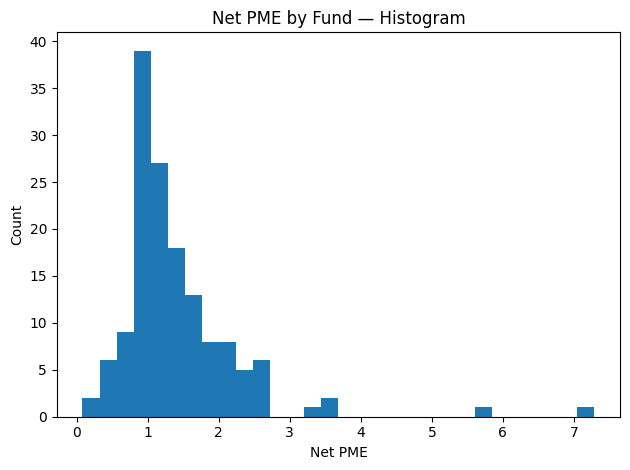

[VIS] deal_to_fund.csv not found or empty — gross PME by fund histogram skipped.


<Figure size 640x480 with 0 Axes>

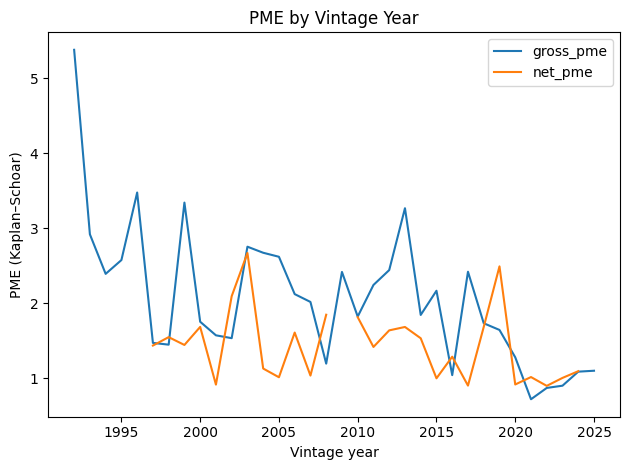


[EXPORT] Wrote:
 - pme_by_vintage.csv
 - per_fund_net_pme.csv


In [67]:
# ===================== PME SENSITIVITY + VISUALS =====================
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---- helpers from your core (assumed imported in the notebook/kernel) ----
# from pme_core import (
#     load_composite_usd_series, ks_pme_ratio, ks_pme_all_funds,
#     vintage_pme_deals, vintage_pme_funds, aggregate_same_day, clip_to_index_end
# )

def _amt_col(df):
    return "amount_usd" if "amount_usd" in df.columns else "amount"

# ---------------------------------------------------------------------
# 0) Load composite and prep
# ---------------------------------------------------------------------
comp = load_composite_usd_series()
DATA_DIR = Path(find_upwards(Path("GrossToNet/Data")))

# ---------------------------------------------------------------------
# 1) Baseline POOLED PMEs (incl. NAV for funds, incl. FV for deals)
# ---------------------------------------------------------------------
# Deals baseline (investments, proceeds, FAIR_VALUE)
deals_cf = deals[["date", _amt_col(deals)]].dropna()
deals_cf = aggregate_same_day(deals_cf, "date", _amt_col(deals))
deals_cf = clip_to_index_end(deals_cf, comp, "date", _amt_col(deals))
gross_pme = ks_pme_ratio(deals_cf, comp, amount_col=_amt_col(deals), date_col="date")

# Funds baseline (contributions, distributions, NAV)
tcol = "type_std" if "type_std" in funds.columns else "cash_flow_type"
funds_std = funds.copy()
funds_std[tcol] = funds_std[tcol].astype(str).str.strip().str.lower()
funds_cf = funds_std.loc[
    funds_std[tcol].isin(["contribution","distribution","nav"]),
    ["date", _amt_col(funds)]
].dropna()
funds_cf = aggregate_same_day(funds_cf, "date", _amt_col(funds))
funds_cf = clip_to_index_end(funds_cf, comp, "date", _amt_col(funds))
net_pme = ks_pme_ratio(funds_cf, comp, amount_col=_amt_col(funds), date_col="date")

fee_drag_delta = gross_pme - net_pme
fee_drag_ratio = (net_pme / gross_pme) if pd.notna(gross_pme) and gross_pme != 0 else np.nan

print("=== POOLED PME (Baseline; incl. NAV/FV) ===")
print(f"GROSS PME (deals) : {gross_pme:0.4f}")
print(f"NET   PME (funds) : {net_pme:0.4f}")
print(f"FEE DRAG Δ (gross - net): {fee_drag_delta:0.4f}")
print(f"FEE DRAG ratio (net/gross): {fee_drag_ratio:0.4f} (~{(1-fee_drag_ratio)*100:0.1f}% of gross PME lost)")

# ---------------------------------------------------------------------
# 2) Sensitivity: REALIZED ONLY (exclude NAV/FV)
# ---------------------------------------------------------------------
# Deals realized-only: drop FAIR_VALUE (keep investments & proceeds)
if "type_std" in deals.columns:
    deals_real = deals[deals["type_std"].str.lower().isin(["investment","proceed"])][["date", _amt_col(deals)]].dropna()
else:
    # if no standardized type column, assume FV labeled includes 'fair'
    deals_real = deals[~deals.get("cash_flow_type","").astype(str).str.lower().str.contains("fair")][["date", _amt_col(deals)]].dropna()

deals_real = aggregate_same_day(deals_real, "date", _amt_col(deals))
deals_real = clip_to_index_end(deals_real, comp, "date", _amt_col(deals))
gross_pme_realized = ks_pme_ratio(deals_real, comp, amount_col=_amt_col(deals), date_col="date")

# Funds realized-only: drop NAV (keep contributions & distributions)
funds_real = funds_std.loc[
    funds_std[tcol].isin(["contribution","distribution"]),
    ["date", _amt_col(funds)]
].dropna()
funds_real = aggregate_same_day(funds_real, "date", _amt_col(funds))
funds_real = clip_to_index_end(funds_real, comp, "date", _amt_col(funds))
net_pme_realized = ks_pme_ratio(funds_real, comp, amount_col=_amt_col(funds), date_col="date")

print("\n=== Sensitivity: REALIZED ONLY (exclude NAV/FV) ===")
print(f"GROSS PME (realized only) : {gross_pme_realized:0.4f}")
print(f"NET   PME (realized only) : {net_pme_realized:0.4f}")
print("Δ vs baseline (gross): {:+0.4f}".format(gross_pme_realized - gross_pme))
print("Δ vs baseline (net)  : {:+0.4f}".format(net_pme_realized - net_pme))

def pme_components_inline(cf, idx, amt_col, date_col="date"):
    cf2 = cf[[date_col, amt_col]].dropna().copy()
    cf2 = cf2.groupby(date_col, as_index=False)[amt_col].sum()
    I = (pd.merge_asof(
            cf2[[date_col]].sort_values(date_col),
            idx.rename('I').rename_axis('date').reset_index(),
            left_on=date_col, right_on='date', direction='backward'
        ).set_index(date_col)['I']).to_numpy()
    shares = cf2[amt_col].to_numpy() / I
    num = shares[shares > 0].sum()
    den = (-shares[shares < 0]).sum()
    return float(num), float(den)

g_num_r, g_den_r = pme_components_inline(deals_real, comp, _amt_col(deals))
n_num_r, n_den_r = pme_components_inline(funds_real, comp, _amt_col(funds))
print(f"[Realized-only components] Gross:  num={g_num_r:,.2f}  den={g_den_r:,.2f}")
print(f"[Realized-only components] Net  :  num={n_num_r:,.2f}  den={n_den_r:,.2f}")

# ---------------------------------------------------------------------
# 2B) Sensitivity (matched): realized-only GROSS PME restricted to deals
#     that map to funds present in the realized-only NET pool.
#     -> place this right after the realized-only block
# ---------------------------------------------------------------------
MAP_CSV = DATA_DIR / "deal_to_fund.csv"

if MAP_CSV.exists():
    map_df = pd.read_csv(MAP_CSV, dtype={"deal_id": str, "fund_id": str})

    # Funds that actually appear in the realized-only net set (i.e., have contrib/dist)
    # This avoids including deals from funds that aren't in the realized comparison.
    funds_real_ids = (
        funds_std.loc[funds_std[tcol].isin(["contribution","distribution"]), "fund_id"]
        .astype(str).unique()
    )

    # Keep only deals that belong to those funds
    map_df = map_df[map_df["fund_id"].astype(str).isin(funds_real_ids)].drop_duplicates()

    # Join deals to funds; realized-only on deals: investments + proceeds (no FAIR_VALUE)
    deals_m = deals.merge(map_df, on="deal_id", how="inner")
    if "type_std" in deals_m.columns:
        deals_m_real = deals_m[deals_m["type_std"].str.lower().isin(["investment","proceed"])]
    else:
        deals_m_real = deals_m[
            ~deals_m.get("cash_flow_type","").astype(str).str.lower().str.contains("fair")
        ]

    # Aggregate, clip to index end, compute PME
    a_deals_m = _amt_col(deals_m_real)
    dmr_cf = deals_m_real[["date", a_deals_m]].dropna()
    dmr_cf = dmr_cf.groupby("date", as_index=False)[a_deals_m].sum()
    dmr_cf = clip_to_index_end(dmr_cf, comp, "date", a_deals_m)

    gross_pme_realized_matched = ks_pme_ratio(dmr_cf, comp, amount_col=a_deals_m, date_col="date")

    # Components (diagnostic)
    def _pme_components(cf, idx, amt_col, date_col="date"):
        cf2 = cf[[date_col, amt_col]].dropna().copy()
        cf2 = cf2.groupby(date_col, as_index=False)[amt_col].sum()
        I = (pd.merge_asof(
                cf2[[date_col]].sort_values(date_col),
                idx.rename('I').rename_axis('date').reset_index(),
                left_on=date_col, right_on='date', direction='backward'
            ).set_index(date_col)['I']).to_numpy()
        shares = cf2[amt_col].to_numpy() / I
        num = shares[shares > 0].sum()
        den = (-shares[shares < 0]).sum()
        return float(num), float(den)

    g_num_rm, g_den_rm = _pme_components(dmr_cf, comp, a_deals_m)

    print("\n=== Sensitivity: Realized-only (Matched to Funds) ===")
    print(f"GROSS PME (realized, matched) : {gross_pme_realized_matched:0.4f}")
    print(f"Components: Σdist/I={g_num_rm:,.2f}  Σcontrib/I={g_den_rm:,.2f}")
    print("Comparison vs realized-only (unmatched): {:+0.4f}".format(
        gross_pme_realized_matched - gross_pme_realized
    ))
else:
    print("[Sensitivity matched] deal_to_fund.csv not found; skipping matched realized gross PME.")


# ---------------------------------------------------------------------
# 3) Per-fund PMEs
#    - Net PME per fund (incl. NAV)
#    - Gross PME per fund (requires deal_to_fund.csv)
# ---------------------------------------------------------------------
# Net by fund
net_by_fund = ks_pme_all_funds(funds, comp, include_nav=True).rename("net_pme")

# Gross by fund (if mapping available)
MAP_CSV = DATA_DIR / "deal_to_fund.csv"
gross_by_fund = None
if MAP_CSV.exists():
    map_df = pd.read_csv(MAP_CSV, dtype={"deal_id": str, "fund_id": str})
    deals_mapped = deals.merge(map_df, on="deal_id", how="inner")
    # investments, proceeds, FAIR_VALUE included
    gross_by_fund = {}
    a_deals = _amt_col(deals_mapped)
    for fid, g in deals_mapped.groupby("fund_id", dropna=False):
        g_cf = g[["date", a_deals]].dropna()
        if not g_cf.empty:
            g_cf = aggregate_same_day(g_cf, "date", a_deals)
            g_cf = clip_to_index_end(g_cf, comp, "date", a_deals)
            gross_by_fund[fid] = ks_pme_ratio(g_cf, comp, amount_col=a_deals, date_col="date")
    gross_by_fund = pd.Series(gross_by_fund, name="gross_pme")

# ---------------------------------------------------------------------
# 4) Vintage PMEs: 2-line time series (gross & net)
# ---------------------------------------------------------------------
gross_by_vintage = vintage_pme_deals(deals, comp, include_fair_value=True).rename("gross_pme")
net_by_vintage   = vintage_pme_funds(funds, comp, include_nav=True).rename("net_pme")

vint_index = sorted(set(gross_by_vintage.index).union(set(net_by_vintage.index)))
vintage_df = pd.DataFrame({
    "gross_pme": gross_by_vintage.reindex(vint_index),
    "net_pme":   net_by_vintage.reindex(vint_index),
})
# ---------------------------------------------------------------------
# 5) Visuals
#   (A) Histogram: Net PME by fund
#   (B) Histogram: Gross PME by fund (if mapping available)
#   (C) Vintage line chart: two lines (gross & net)
# ---------------------------------------------------------------------
plt.figure()
plt.hist(net_by_fund.dropna().values, bins=30)
plt.title("Net PME by Fund — Histogram")
plt.xlabel("Net PME")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

if isinstance(gross_by_fund, pd.Series) and not gross_by_fund.dropna().empty:
    plt.figure()
    plt.hist(gross_by_fund.dropna().values, bins=30)
    plt.title("Gross PME by Fund — Histogram")
    plt.xlabel("Gross PME")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
else:
    print("[VIS] deal_to_fund.csv not found or empty — gross PME by fund histogram skipped.")

plt.figure()
ax = vintage_df.sort_index().plot(y=["gross_pme","net_pme"])
ax.set_title("PME by Vintage Year")
ax.set_xlabel("Vintage year")
ax.set_ylabel("PME (Kaplan–Schoar)")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# 6) Optional: export tables
# ---------------------------------------------------------------------
(vintage_df
 .reset_index(names="vintage")
 .to_csv(DATA_DIR / "pme_by_vintage.csv", index=False))

net_by_fund.rename_axis("fund_id").reset_index().to_csv(DATA_DIR / "per_fund_net_pme.csv", index=False)
if isinstance(gross_by_fund, pd.Series) and not gross_by_fund.dropna().empty:
    (pd.concat([gross_by_fund, net_by_fund], axis=1)
       .rename_axis("fund_id")
       .reset_index()
       .to_csv(DATA_DIR / "per_fund_gross_vs_net_pme.csv", index=False))

print("\n[EXPORT] Wrote:")
print(" - pme_by_vintage.csv")
print(" - per_fund_net_pme.csv")
if isinstance(gross_by_fund, pd.Series) and not gross_by_fund.dropna().empty:
    print(" - per_fund_gross_vs_net_pme.csv")


=== POOLED PME (2010+; incl. NAV/FV) ===
GROSS PME (deals) : 1.6434
NET   PME (funds) : 1.7871
FEE DRAG Δ (gross - net): -0.1437
FEE DRAG ratio (net/gross): 1.0875 (~-8.7% of gross PME lost)

=== Sensitivity (2010+): REALIZED ONLY ===
GROSS PME (realized) : 0.9351
NET   PME (realized) : 1.3251
Δ vs baseline (gross): -0.7083
Δ vs baseline (net)  : -0.4620
[FILTER] Funds < $50,000,000 contributed USD: excluded 10 funds (median contrib of dropped = $35,813,011).


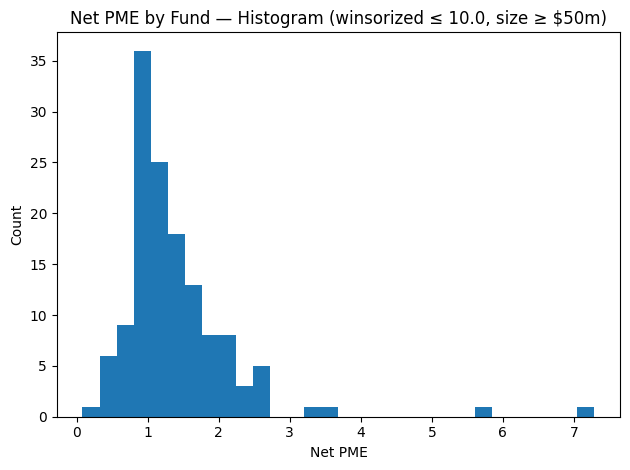

[VIS] Gross PME by fund histogram skipped (no data after filters).
[EXPORT] Wrote filtered per-fund PME tables.


<Figure size 640x480 with 0 Axes>

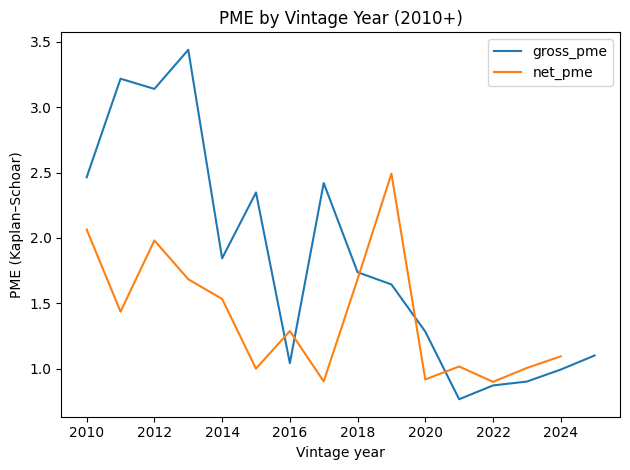

In [68]:
# ===================== PME (2010 onward) — KPIs + Sensitivity + Visuals =====================
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# assumes helpers already in scope:
# load_composite_usd_series, ks_pme_ratio, ks_pme_all_funds,
# vintage_pme_deals, vintage_pme_funds, aggregate_same_day, clip_to_index_end, find_upwards

def _amt_col(df):
    return "amount_usd" if "amount_usd" in df.columns else "amount"

START = pd.Timestamp("2010-01-01")

# Filter to last ~15 years (keep only flows >= START)
deals_2010 = deals.loc[pd.to_datetime(deals["date"]) >= START].copy()
funds_2010 = funds.loc[pd.to_datetime(funds["date"]) >= START].copy()

# Composite (unchanged)
comp = load_composite_usd_series()
DATA_DIR = Path(find_upwards(Path("GrossToNet/Data")))

# ---------- 1) Baseline pooled PMEs (incl. FV / incl. NAV) ----------
# Deals pooled (incl. FV)
d_cf = deals_2010[["date", _amt_col(deals_2010)]].dropna()
d_cf = aggregate_same_day(d_cf, "date", _amt_col(deals_2010))
d_cf = clip_to_index_end(d_cf, comp, "date", _amt_col(deals_2010))
gross_pme_2010 = ks_pme_ratio(d_cf, comp, amount_col=_amt_col(deals_2010), date_col="date")

# Funds pooled (incl. NAV)
tcol = "type_std" if "type_std" in funds_2010.columns else "cash_flow_type"
f_std = funds_2010.copy()
f_std[tcol] = f_std[tcol].astype(str).str.strip().str.lower()
f_cf = f_std.loc[f_std[tcol].isin(["contribution","distribution","nav"]), ["date", _amt_col(funds_2010)]].dropna()
f_cf = aggregate_same_day(f_cf, "date", _amt_col(funds_2010))
f_cf = clip_to_index_end(f_cf, comp, "date", _amt_col(funds_2010))
net_pme_2010 = ks_pme_ratio(f_cf, comp, amount_col=_amt_col(funds_2010), date_col="date")

fee_drag_delta_2010 = gross_pme_2010 - net_pme_2010
fee_drag_ratio_2010 = (net_pme_2010 / gross_pme_2010) if pd.notna(gross_pme_2010) and gross_pme_2010 != 0 else np.nan

print("=== POOLED PME (2010+; incl. NAV/FV) ===")
print(f"GROSS PME (deals) : {gross_pme_2010:0.4f}")
print(f"NET   PME (funds) : {net_pme_2010:0.4f}")
print(f"FEE DRAG Δ (gross - net): {fee_drag_delta_2010:0.4f}")
print(f"FEE DRAG ratio (net/gross): {fee_drag_ratio_2010:0.4f} (~{(1-fee_drag_ratio_2010)*100:0.1f}% of gross PME lost)")

# ---------- 2) Realized-only sensitivity (exclude FV/NAV) ----------
# Deals realized-only
if "type_std" in deals_2010.columns:
    d_real = deals_2010[deals_2010["type_std"].str.lower().isin(["investment","proceed"])][["date", _amt_col(deals_2010)]].dropna()
else:
    d_real = deals_2010[~deals_2010.get("cash_flow_type","").astype(str).str.lower().str.contains("fair")][["date", _amt_col(deals_2010)]].dropna()
d_real = aggregate_same_day(d_real, "date", _amt_col(deals_2010))
d_real = clip_to_index_end(d_real, comp, "date", _amt_col(deals_2010))
gross_pme_real_2010 = ks_pme_ratio(d_real, comp, amount_col=_amt_col(deals_2010), date_col="date")

# Funds realized-only
f_real = f_std.loc[f_std[tcol].isin(["contribution","distribution"]), ["date", _amt_col(funds_2010)]].dropna()
f_real = aggregate_same_day(f_real, "date", _amt_col(funds_2010))
f_real = clip_to_index_end(f_real, comp, "date", _amt_col(funds_2010))
net_pme_real_2010 = ks_pme_ratio(f_real, comp, amount_col=_amt_col(funds_2010), date_col="date")

print("\n=== Sensitivity (2010+): REALIZED ONLY ===")
print(f"GROSS PME (realized) : {gross_pme_real_2010:0.4f}")
print(f"NET   PME (realized) : {net_pme_real_2010:0.4f}")
print("Δ vs baseline (gross): {:+0.4f}".format(gross_pme_real_2010 - gross_pme_2010))
print("Δ vs baseline (net)  : {:+0.4f}".format(net_pme_real_2010 - net_pme_2010))

# ---------- 3) Per-fund PMEs (incl. NAV / incl. FV) ----------
# Net by fund (incl. NAV)
net_by_fund_2010 = ks_pme_all_funds(funds_2010, comp, include_nav=True).rename("net_pme")

# Gross by fund (incl. FV) via mapping
gross_by_fund_2010 = None
MAP_CSV = DATA_DIR / "deal_to_fund.csv"
if MAP_CSV.exists():
    map_df = pd.read_csv(MAP_CSV, dtype={"deal_id": str, "fund_id": str})
    deals_map_2010 = deals_2010.merge(map_df, on="deal_id", how="inner")
    gpf = {}
    a_dm = _amt_col(deals_map_2010)
    for fid, g in deals_map_2010.groupby("fund_id", dropna=False):
        g_cf = g[["date", a_dm]].dropna()
        if not g_cf.empty:
            g_cf = aggregate_same_day(g_cf, "date", a_dm)
            g_cf = clip_to_index_end(g_cf, comp, "date", a_dm)
            gpf[fid] = ks_pme_ratio(g_cf, comp, amount_col=a_dm, date_col="date")
    gross_by_fund_2010 = pd.Series(gpf, name="gross_pme")

# ---------------- Outlier control & denominator sanity ---------------- #
PME_MIN, PME_MAX = 0.0, 10.0            # keep (0, 10]
MIN_CONTRIB_USD  = 50_000_000           # optional size screen; set to 0 to disable

def _series_filter_pme(s: pd.Series, label: str) -> pd.Series:
    s0 = s.copy()
    # Range filter
    in_range = (s0 > PME_MIN) & (s0 <= PME_MAX)
    outliers = (~in_range) & s0.notna()
    if outliers.any():
        print(f"[FILTER] {label}: excluded {int(outliers.sum())} outliers outside ({PME_MIN}, {PME_MAX}] "
              f"(min={float(s0.min()):.4g}, max={float(s0.max()):.4g})")
    return s0[in_range]

def _size_screen_funds(funds_df: pd.DataFrame, min_contrib_usd: float) -> pd.Index:
    """Return fund_ids with absolute contributed USD >= threshold (contributions are negative)."""
    amt_col = "amount_usd" if "amount_usd" in funds_df.columns else "amount"
    tcol    = "type_std" if "type_std" in funds_df.columns else "cash_flow_type"
    f = funds_df.copy()
    f[tcol] = f[tcol].astype(str).str.strip().str.lower()
    contrib = f[f[tcol].eq("contribution")]
    by_fund = contrib.groupby("fund_id")[amt_col].sum().abs()
    keep_ids = by_fund[by_fund >= min_contrib_usd].index
    dropped  = by_fund[by_fund < min_contrib_usd]
    if min_contrib_usd > 0 and len(dropped) > 0:
        print(f"[FILTER] Funds < ${min_contrib_usd:,.0f} contributed USD: excluded {len(dropped)} funds "
              f"(median contrib of dropped = ${float(dropped.median()):,.0f}).")
    return pd.Index(keep_ids)

# ---- apply to NET (per fund) ----
net_plot = net_by_fund.copy()
if MIN_CONTRIB_USD > 0:
    big_ids = _size_screen_funds(funds, MIN_CONTRIB_USD)
    net_plot = net_plot[net_plot.index.isin(big_ids)]
net_plot = _series_filter_pme(net_plot, "Net PME by fund")

# ---- apply to GROSS (per fund), if available ----
gross_plot = None
if isinstance(gross_by_fund, pd.Series):
    gross_plot = gross_by_fund.copy()
    if MIN_CONTRIB_USD > 0:
        # size screen uses fund contributions; re-use big_ids if computed, else compute now
        if 'big_ids' not in locals():
            big_ids = _size_screen_funds(funds, MIN_CONTRIB_USD)
        gross_plot = gross_plot[gross_plot.index.isin(big_ids)]
    gross_plot = _series_filter_pme(gross_plot, "Gross PME by fund")

# ---------------- Histograms using filtered series ---------------- #
plt.figure()
plt.hist(net_plot.dropna().values, bins=30)
plt.title(f"Net PME by Fund — Histogram (winsorized ≤ {PME_MAX}, size ≥ ${MIN_CONTRIB_USD/1e6:.0f}m)")
plt.xlabel("Net PME"); plt.ylabel("Count"); plt.tight_layout(); plt.show()

if isinstance(gross_plot, pd.Series) and not gross_plot.dropna().empty:
    plt.figure()
    plt.hist(gross_plot.dropna().values, bins=30)
    plt.title(f"Gross PME by Fund — Histogram (winsorized ≤ {PME_MAX}, size ≥ ${MIN_CONTRIB_USD/1e6:.0f}m)")
    plt.xlabel("Gross PME"); plt.ylabel("Count"); plt.tight_layout(); plt.show()
else:
    print("[VIS] Gross PME by fund histogram skipped (no data after filters).")

# ---------------- Exports (filtered) ---------------- #
net_plot.rename("net_pme").rename_axis("fund_id").reset_index() \
    .to_csv(DATA_DIR / "per_fund_net_pme_filtered.csv", index=False)

if isinstance(gross_plot, pd.Series) and not gross_plot.dropna().empty:
    (pd.concat([gross_plot.rename("gross_pme"), net_plot.rename("net_pme")], axis=1)
       .dropna(how="all")
       .rename_axis("fund_id")
       .reset_index()
       .to_csv(DATA_DIR / "per_fund_gross_vs_net_pme_filtered.csv", index=False))
print("[EXPORT] Wrote filtered per-fund PME tables.")


# ---------- 4) Vintage PMEs (incl. NAV/FV) ----------
# Note: vintages are computed within the filtered window by our helpers (first negative flow in 2010+ data)
gross_by_vintage_2010 = vintage_pme_deals(deals_2010, comp, include_fair_value=True).rename("gross_pme")
net_by_vintage_2010   = vintage_pme_funds(funds_2010, comp, include_nav=True).rename("net_pme")

vintages = sorted(set(gross_by_vintage_2010.index).union(set(net_by_vintage_2010.index)))
vintage_df_2010 = pd.DataFrame({
    "gross_pme": gross_by_vintage_2010.reindex(vintages),
    "net_pme":   net_by_vintage_2010.reindex(vintages),
})

# (C) Vintage line (incl. NAV/FV)
plt.figure()
ax = vintage_df_2010.sort_index().plot(y=["gross_pme","net_pme"])
ax.set_title("PME by Vintage Year (2010+)")
ax.set_xlabel("Vintage year")
ax.set_ylabel("PME (Kaplan–Schoar)")
plt.tight_layout()
plt.show()
